# Import modules and load data

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import pickle
import operator
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time
acc = make_scorer(accuracy_score)


from sklearn.multiclass import OneVsRestClassifier

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import random

def sampleData(DataFrame, ratio):
    df_size = len(DataFrame.index)
    sample_size = int(round(ratio * df_size))
    if sample_size == df_size:
        sample_size = sample_size - 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    elif sample_size == 0:
        sample_size = 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    else:
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

In [3]:
def drop_almost_zero(df, percentage):
    row_cut_off = int(percentage/100*len(df.columns))
    df = df[(df==0).sum(axis='columns') <= row_cut_off]

    column_cut_off = int(percentage/100*len(df)) 
    b = (df == 0).sum(axis='rows')
    df = df[ b[ b <= column_cut_off].index.values ]

    return df


In [4]:
#import data
atlas = pd.read_csv('/home/compomics/git/MLMarker/data/tissue_predictor_notfiltered_healthy_nofluid_2206.csv', sep="/")
atlas.head()

A0A024RBG1  A0A075B6H7  A0A075B6H8  A0A075B6H9  A0A075B6I0  A0A075B6I1  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   A0A075B6I7  A0A075B6I9  A0A075B6J1  A0A075B6J6  ...  Q9Y6Y8  Q9Y6Y9  \
0         0.0         0.0         0.0         0.0  ...     0.0     0.0   
1         0.0         0.0         0.0         0.0  ...     0.0     0.0   
2         0.0         0.0         0.0         0.0  ...     0.0     0.0   
3         0.0         0.0         0.0         0.0  ...     0.0     0.0   
4         0.0         0.0         0.0         0.0  ...     0.0     0.0   

   Q9Y6Z4  Q9Y6Z5  Q9Y6Z7  W5XKT8  cell_type  tissue_name  disease_status  \
0     0.0     0.0     0.0     0.0      Brain        Brain         Healthy   
1     0.0     0.0     0.0     0.0      Brain        Brain         Healthy   
2     0.0     0.0     0.0     0.0      Brain        Brain         Healthy   
3     0.0     0.0     0.0     0.0      Brain        Brain         Healthy   
4     0.0     0.0     0.0     0.0      Brain        Brain         Healthy   

   fluid  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 11789 columns]

In [5]:
exclude_tissues = ['Dental plaque', 'hMSC', 'Hela', 'Unknown', 'Cartilage', 'Tooth', 'Microvessel', 'T-cells']
atlas = atlas[~atlas['tissue_name'].isin(exclude_tissues)]
atlas = atlas.replace({'Cervix': 'Uterine cervix'})
print(atlas.shape)

(2268, 11789)


In [8]:
for p in range(85,101,1):
    new_atlas = drop_almost_zero(atlas, p)
    print(f'percentage: {p} ==> {new_atlas.shape[0]} rows')

percentage: 85 ==> 238 rows
percentage: 86 ==> 336 rows
percentage: 87 ==> 429 rows
percentage: 88 ==> 550 rows
percentage: 89 ==> 649 rows
percentage: 90 ==> 810 rows
percentage: 91 ==> 946 rows
percentage: 92 ==> 1093 rows
percentage: 93 ==> 1236 rows
percentage: 94 ==> 1387 rows
percentage: 95 ==> 1512 rows
percentage: 96 ==> 1656 rows
percentage: 97 ==> 1818 rows
percentage: 98 ==> 1949 rows
percentage: 99 ==> 2058 rows
percentage: 100 ==> 2268 rows


In [9]:
atlas=drop_almost_zero(atlas, 92)
print(atlas.shape)

(1093, 4387)


## Check the class balance

<Axes: ylabel='count'>

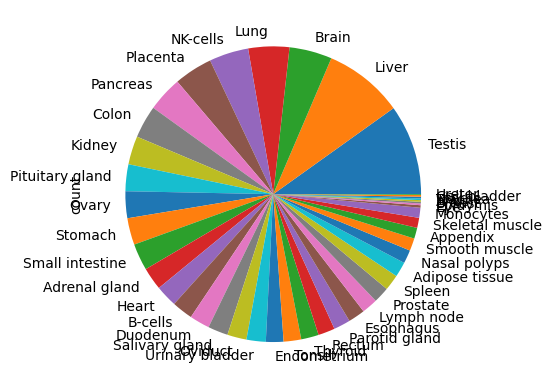

In [10]:
atlas['tissue_name'].value_counts().plot.pie()

We will balance the atlas a little bit by dropping the tissues that are too low. 

In [11]:
pd.set_option('display.max_rows', None)  
tissue_counts = atlas['tissue_name'].value_counts().to_frame(name='tissue_name')
print(tissue_counts)

                 tissue_name
tissue_name                 
Testis                   108
Liver                     95
Brain                     51
Lung                      49
NK-cells                  47
Placenta                  46
Pancreas                  42
Colon                     39
Kidney                    34
Pituitary gland           32
Ovary                     32
Stomach                   32
Small intestine           32
Adrenal gland             27
Heart                     26
B-cells                   25
Duodenum                  24
Salivary gland            24
Oviduct                   23
Urinary bladder           23
Endometrium               21
Tonsil                    21
Thyroid                   21
Rectum                    20
Parotid gland             20
Esophagus                 20
Lymph node                19
Prostate                  19
Spleen                    19
Adipose tissue            18
Nasal polyps              16
Smooth muscle             15
Appendix      

# Drop low tissues

In [12]:
low_tissues = tissue_counts.index[tissue_counts['tissue_name']<10].tolist()
atlas = atlas[~atlas['tissue_name'].isin(low_tissues)]

In [13]:
atlas.head()

A0A075B6H7  A0A075B6I0  A0A075B6Q5  A0A0A0MS14  A0A0A0MS15  A0A0B4J1U7  \
14    0.000000    0.000000         0.0    0.000000    0.000000         0.0   
15    0.000000    0.000183         0.0    0.000095    0.000000         0.0   
16    0.000615    0.000146         0.0    0.000000    0.000000         0.0   
17    0.000000    0.000000         0.0    0.000053    0.000105         0.0   
19    0.000000    0.000000         0.0    0.000000    0.000000         0.0   

    A0A0B4J1V0  A0A0B4J1V6  A0A0B4J1X8  A0A0B4J2F0  ...    Q9Y6W3    Q9Y6W5  \
14    0.000388         0.0         0.0    0.000000  ...  0.000000  0.000000   
15    0.000000         0.0         0.0    0.000413  ...  0.000000  0.000067   
16    0.000000         0.0         0.0    0.000000  ...  0.000000  0.000000   
17    0.000053         0.0         0.0    0.000347  ...  0.000100  0.000352   
19    0.000238         0.0         0.0    0.000131  ...  0.000017  0.000312   

      Q9Y6X5    Q9Y6X8    Q9Y6X9   Q9Y6Y0    Q9Y6Y8      cell_type  \
14  0.000000  0.000000  0.000179  0.00000  0.000000  Adrenal gland   
15  0.000000  0.000000  0.000000  0.00000  0.000179  Adrenal gland   
16  0.000000  0.000000  0.000000  0.00000  0.000000  Adrenal gland   
17  0.000152  0.000209  0.000073  0.00001  0.000250        B-cells   
19  0.000078  0.000000  0.000000  0.00000  0.000170        B-cells   

      tissue_name  disease_status  
14  Adrenal gland         Healthy  
15  Adrenal gland         Healthy  
16  Adrenal gland         Healthy  
17        B-cells         Healthy  
19        B-cells         Healthy  

[5 rows x 4387 columns]

In [24]:
#in all but the last three columns, make the atlas binary
atlas_binary = atlas.copy()
atlas_binary.iloc[:, 0:-3] = np.where(atlas_binary.iloc[:, 0:-3] != 0, 1, 0)
atlas_binary.head()

A0A075B6H7  A0A075B6I0  A0A075B6Q5  A0A0A0MS14  A0A0A0MS15  A0A0B4J1U7  \
14         0.0         0.0         0.0         0.0         0.0         0.0   
15         0.0         1.0         0.0         1.0         0.0         0.0   
16         1.0         1.0         0.0         0.0         0.0         0.0   
17         0.0         0.0         0.0         1.0         1.0         0.0   
19         0.0         0.0         0.0         0.0         0.0         0.0   

    A0A0B4J1V0  A0A0B4J1V6  A0A0B4J1X8  A0A0B4J2F0  ...  Q9Y6W3  Q9Y6W5  \
14         1.0         0.0         0.0         0.0  ...     0.0     0.0   
15         0.0         0.0         0.0         1.0  ...     0.0     1.0   
16         0.0         0.0         0.0         0.0  ...     0.0     0.0   
17         1.0         0.0         0.0         1.0  ...     1.0     1.0   
19         1.0         0.0         0.0         1.0  ...     1.0     1.0   

    Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y8      cell_type    tissue_name  \
14     0.0     0.0     1.0     0.0     0.0  Adrenal gland  Adrenal gland   
15     0.0     0.0     0.0     0.0     1.0  Adrenal gland  Adrenal gland   
16     0.0     0.0     0.0     0.0     0.0  Adrenal gland  Adrenal gland   
17     1.0     1.0     1.0     1.0     1.0        B-cells        B-cells   
19     1.0     0.0     0.0     0.0     1.0        B-cells        B-cells   

    disease_status  
14         Healthy  
15         Healthy  
16         Healthy  
17         Healthy  
19         Healthy  

[5 rows x 4387 columns]

In [27]:
atlas_binary.to_csv('/home/compomics/git/MLMarker/data/training_atlas_binary_92%_10exp.csv', index=False)

In [28]:
atlas = atlas_binary

In [26]:
tf = dict(Counter(atlas['tissue_name']))
tf = sorted(tf.items(), key=operator.itemgetter(1), reverse=True)
tf = dict(tf)

# Using class weight in the predictors <br>
To further balance the algorithm, the class will be assigned a specific weight based on the number of samples in this class. 

The weight of a class is determined by dividing negative samples/ positive samples. So if a class contains 15 samples in a dataset of 100 samples, the class weight will be 85/15=5,667

In [29]:
atlas=atlas.drop(columns=['cell_type', 'disease_status'])
atlas.head()

A0A075B6H7  A0A075B6I0  A0A075B6Q5  A0A0A0MS14  A0A0A0MS15  A0A0B4J1U7  \
14         0.0         0.0         0.0         0.0         0.0         0.0   
15         0.0         1.0         0.0         1.0         0.0         0.0   
16         1.0         1.0         0.0         0.0         0.0         0.0   
17         0.0         0.0         0.0         1.0         1.0         0.0   
19         0.0         0.0         0.0         0.0         0.0         0.0   

    A0A0B4J1V0  A0A0B4J1V6  A0A0B4J1X8  A0A0B4J2F0  ...  Q9Y6V0  Q9Y6V7  \
14         1.0         0.0         0.0         0.0  ...     0.0     0.0   
15         0.0         0.0         0.0         1.0  ...     0.0     0.0   
16         0.0         0.0         0.0         0.0  ...     0.0     0.0   
17         1.0         0.0         0.0         1.0  ...     0.0     1.0   
19         1.0         0.0         0.0         1.0  ...     1.0     0.0   

    Q9Y6W3  Q9Y6W5  Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y8    tissue_name  
14     0.0     0.0     0.0     0.0     1.0     0.0     0.0  Adrenal gland  
15     0.0     1.0     0.0     0.0     0.0     0.0     1.0  Adrenal gland  
16     0.0     0.0     0.0     0.0     0.0     0.0     0.0  Adrenal gland  
17     1.0     1.0     1.0     1.0     1.0     1.0     1.0        B-cells  
19     1.0     1.0     1.0     0.0     0.0     0.0     1.0        B-cells  

[5 rows x 4385 columns]

In [30]:
X = atlas.iloc[:, :-1]
y = atlas[['tissue_name']]

In [31]:
som = atlas.shape[0]
weight_and_label = pd.DataFrame(columns=['label', 'weight'])
i = 0
for key, value in tf.items():
    i += 1
    w = (som - value)/value
    weight_and_label.loc[i] = [key, w]

In [32]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
validation_df = pd.DataFrame()

tissues = atlas['tissue_name'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict.keys():
    DataFrameDict[key] = atlas[:][atlas['tissue_name'] == key]

for key in DataFrameDict.keys():
    train = sampleData(DataFrameDict[key], 0.80)
    train_df = pd.concat([train_df, train])

    test = DataFrameDict[key].drop(train.index)
    test_df = pd.concat([test_df, test])

y_train = train_df.pop('tissue_name').values
X_train = train_df.values
y_test = test_df.pop('tissue_name').values
X_test = test_df.values

X_train = pd.DataFrame(X_train, columns=(atlas.columns)[:-1])
X_test = pd.DataFrame(X_test, columns=(atlas.columns)[:-1])

In [33]:
train_label_weight = pd.merge(pd.DataFrame(y_train, columns=['label']), weight_and_label, how='left', on='label')
label_weight = pd.merge(pd.DataFrame(atlas['tissue_name'], columns=['label']), weight_and_label, how='left', on='label')

The weights are linked to the targets in the training data and in the complete dataset.

In [34]:
train_weights = train_label_weight['weight'].to_numpy()
train_weights = train_weights.flatten()
train_weights

weights = label_weight['weight'].to_numpy()
weights = weights.flatten()
weights

array([], dtype=float64)

In [35]:
dict_train_label_weight = train_label_weight.drop_duplicates()
dict_train_label_weights = dict(zip(train_label_weight.label, train_label_weight.weight))

# RandomForest

In [36]:
result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])
result_df_cv = pd.DataFrame(columns=['model','fold', 'Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])

In [37]:
forest= RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
forest.fit(X_train, y_train)
baseline_predictions =  forest.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_baseline', acc, fm, pm, rm, fw, pm, rw]

In [38]:
result_df

model  Accuracy  f1_macro  precision_macro  recall_macro  \
0  RandomForest_baseline  0.906542  0.862259         0.868095      0.868333   

   f1_weighted  precision_weighted  recall_weighted  
0      0.89539            0.868095         0.906542

In [23]:
fold_number = 0
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    fold_number += 1
    train = atlas.iloc[train_index,:]
    X_train_cv = train.iloc[:,:-1]
    y_train_cv = train.iloc[:,-1]
    test = atlas.iloc[test_index,:]
    X_test_cv = test.iloc[:, :-1]
    y_test_cv = test.iloc[:,-1]
    forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
    forest.fit(X_train_cv, y_train_cv)
    importances = forest.feature_importances_
    baseline_predictions =  forest.predict(X_test_cv)
    fm = f1_score(y_test_cv, baseline_predictions, average="macro")
    fw = f1_score(y_test_cv, baseline_predictions, average="weighted")
    acc = accuracy_score(y_test_cv, baseline_predictions)
    pw = precision_score(y_test_cv, baseline_predictions, average='weighted')
    pm = precision_score(y_test_cv, baseline_predictions, average='macro')
    rw = recall_score(y_test_cv, baseline_predictions, average='weighted')
    rm = recall_score(y_test_cv, baseline_predictions, average='macro')
    df_length = len(result_df_cv)
    result_df_cv.loc[df_length] = ['RandomForest_baseline',fold_number, acc, fm, pm, rm, fw, pm, rw]
print(result_df_cv.mean())

/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_cl

fold                  5.500000
Accuracy              0.960116
f1_macro              0.942617
precision_macro       0.951751
recall_macro          0.945619
f1_weighted           0.955031
precision_weighted    0.951751
recall_weighted       0.960116
dtype: float64


In [24]:
result_df_cv

model fold  Accuracy  f1_macro  precision_macro  \
0  RandomForest_baseline    1  0.935185  0.899234         0.905238   
1  RandomForest_baseline    2  0.962963  0.952472         0.970476   
2  RandomForest_baseline    3  0.962963  0.963593         0.981319   
3  RandomForest_baseline    4  0.944444  0.889494         0.878571   
4  RandomForest_baseline    5  0.925926  0.904762         0.916190   
5  RandomForest_baseline    6  0.953704  0.925322         0.940000   
6  RandomForest_baseline    7  0.990741  0.987302         0.994286   
7  RandomForest_baseline    8  0.971963  0.963900         0.977619   
8  RandomForest_baseline    9  0.981308  0.973696         0.987143   
9  RandomForest_baseline   10  0.971963  0.966395         0.966667   

   recall_macro  f1_weighted  precision_weighted  recall_weighted  
0      0.914286     0.918565            0.905238         0.935185  
1      0.952381     0.960788            0.970476         0.962963  
2      0.961905     0.958600            0.981319         0.962963  
3      0.904762     0.924696            0.878571         0.944444  
4      0.901905     0.925309            0.916190         0.925926  
5      0.930476     0.950734            0.940000         0.953704  
6      0.985714     0.989712            0.994286         0.990741  
7      0.964286     0.970301            0.977619         0.971963  
8      0.971429     0.979380            0.987143         0.981308  
9      0.969048     0.972230            0.966667         0.971963

In [ ]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
max_features = ['log2', 'sqrt']
max_depth = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
min_samples_split = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(forest,#sample weights are already in the forest algorithm so no need to add again
param_dist,
n_iter=100,
cv=3,
verbose=2,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

In [ ]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                650                      25                      1   
1                400                      25                      2   
2                500                       2                      2   
3                200                      30                     10   
4                600                      25                     10   
5                750                       2                     15   
6                 50                      20                      1   
7                350                      40                     10   
8                550                      25                     15   
9                950                       5                     15   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               sqrt              70           False         0.962121   
1               sqrt              50            True         0.952862   
2               sqrt              90            True         0.951178   
3               sqrt              30           False         0.949495   
4               sqrt              60            True         0.943603   
5               sqrt              50           False         0.943603   
6               sqrt              30           False         0.942761   
7               sqrt              60            True         0.936869   
8               sqrt              80            True         0.935185   
9               sqrt             110            True         0.935185   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

In [39]:
n_estimators = [650,500,50,400,200]
max_features = ['sqrt', 'log2']
max_depth = [70,90,30,50]
min_samples_split = [25,2,30]
min_samples_leaf = [1,2,10]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(forest,
param_grid,
cv=3,
verbose=2)

gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=25, n_estimators=650; total time=   2.6s


KeyboardInterrupt: 

In [40]:
forest_opt=RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', bootstrap=False,
    min_samples_leaf=1, min_samples_split=30, random_state=42, class_weight='balanced', n_jobs=-1)
forest_opt.fit(X_train, y_train)
baseline_predictions =  forest_opt.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_optimised', acc, fm, pm, rm, fw, pm, rw]

In [26]:
fold_number = 0
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    fold_number += 1
    train = atlas.iloc[train_index,:]
    X_train_cv = train.iloc[:,:-1]
    y_train_cv = train.iloc[:,-1]
    test = atlas.iloc[test_index,:]
    X_test_cv = test.iloc[:, :-1]
    y_test_cv = test.iloc[:,-1]
    forest_optcv = RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', bootstrap=False,
    min_samples_leaf=1, min_samples_split=30, random_state=42, class_weight='balanced', n_jobs=-1)
    forest_optcv.fit(X_train_cv, y_train_cv)
    optimized_predictionscv =  forest_optcv.predict(X_test_cv)
    fm = f1_score(y_test_cv, optimized_predictionscv, average="macro")
    fw = f1_score(y_test_cv, optimized_predictionscv, average="weighted")
    acc = accuracy_score(y_test_cv, optimized_predictionscv)
    pw = precision_score(y_test_cv, optimized_predictionscv, average='weighted')
    pm = precision_score(y_test_cv, optimized_predictionscv, average='macro')
    rw = recall_score(y_test_cv, optimized_predictionscv, average='weighted')
    rm = recall_score(y_test_cv, optimized_predictionscv, average='macro')
    df_length = len(result_df_cv)
    result_df_cv.loc[df_length] = ['RandomForest_optimised',fold_number, acc, fm, pm, rm, fw, pm, rw]
print(result_df_cv.mean())

/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold                  5.500000
Accuracy              0.967991
f1_macro              0.956486
precision_macro       0.964137
recall_macro          0.959894
f1_weighted           0.964462
precision_weighted    0.964137
recall_weighted       0.967991
dtype: float64


In [41]:
result_df

model  Accuracy  f1_macro  precision_macro  recall_macro  \
0   RandomForest_baseline  0.906542  0.862259         0.868095      0.868333   
1  RandomForest_optimised  0.957944  0.947552         0.954286      0.952619   

   f1_weighted  precision_weighted  recall_weighted  
0     0.895390            0.868095         0.906542  
1     0.958072            0.954286         0.957944

In [28]:
result_df_cv

model fold  Accuracy  f1_macro  precision_macro  \
0    RandomForest_baseline    1  0.935185  0.899234         0.905238   
1    RandomForest_baseline    2  0.962963  0.952472         0.970476   
2    RandomForest_baseline    3  0.962963  0.963593         0.981319   
3    RandomForest_baseline    4  0.944444  0.889494         0.878571   
4    RandomForest_baseline    5  0.925926  0.904762         0.916190   
5    RandomForest_baseline    6  0.953704  0.925322         0.940000   
6    RandomForest_baseline    7  0.990741  0.987302         0.994286   
7    RandomForest_baseline    8  0.971963  0.963900         0.977619   
8    RandomForest_baseline    9  0.981308  0.973696         0.987143   
9    RandomForest_baseline   10  0.971963  0.966395         0.966667   
10  RandomForest_optimised    1  0.962963  0.948962         0.942857   
11  RandomForest_optimised    2  0.972222  0.965170         0.973810   
12  RandomForest_optimised    3  0.962963  0.967384         0.980000   
13  RandomForest_optimised    4  0.981481  0.967347         0.978571   
14  RandomForest_optimised    5  0.972222  0.973462         0.973810   
15  RandomForest_optimised    6  0.972222  0.970288         0.977619   
16  RandomForest_optimised    7  1.000000  1.000000         1.000000   
17  RandomForest_optimised    8  0.981308  0.977506         0.984762   
18  RandomForest_optimised    9  0.990654  0.987302         0.994286   
19  RandomForest_optimised   10  0.962617  0.946122         0.959524   

    recall_macro  f1_weighted  precision_weighted  recall_weighted  
0       0.914286     0.918565            0.905238         0.935185  
1       0.952381     0.960788            0.970476         0.962963  
2       0.961905     0.958600            0.981319         0.962963  
3       0.904762     0.924696            0.878571         0.944444  
4       0.901905     0.925309            0.916190         0.925926  
5       0.930476     0.950734            0.940000         0.953704  
6       0.985714     0.989712            0.994286         0.990741  
7       0.964286     0.970301            0.977619         0.971963  
8       0.971429     0.979380            0.987143         0.981308  
9       0.969048     0.972230            0.966667         0.971963  
10      0.961905     0.950863            0.942857         0.962963  
11      0.969048     0.971605            0.973810         0.972222  
12      0.968831     0.959452            0.980000         0.962963  
13      0.971429     0.980600            0.978571         0.981481  
14      0.978095     0.972640            0.973810         0.972222  
15      0.973333     0.971611            0.977619         0.972222  
16      1.000000     1.000000            1.000000         1.000000  
17      0.978571     0.980537            0.984762         0.981308  
18      0.985714     0.989616            0.994286         0.990654  
19      0.954762     0.961994            0.959524         0.962617

In [48]:
def plot_confusion_matrix(cm, y_test, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=90)
    plt.yticks(tick_marks, np.unique(y_test))
    plt.tight_layout()
    plt.grid(color='gainsboro')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, baseline_predictions)
np.set_printoptions(precision=2)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(20,12), dpi=1200)
plot_confusion_matrix(cm_normalized, y_test, title='Normalized confusion matrix')


Normalized confusion matrix
[[1.  0.  0.  ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.  0.  0.8]]


In [42]:
filename = '/home/compomics/git/MLMarker/models/binary_TP_full_92%_10exp_2024.pkl'
pickle.dump(forest_opt, open(filename, 'wb'))

In [43]:
from joblib import dump, load

# Save the model
dump(forest_opt, '/home/compomics/git/MLMarker/models/binary_TP_full_92%_10exp_2024.joblib')

# Load the model
model = load('/home/compomics/git/MLMarker/models/binary_TP_full_92%_10exp_2024.joblib')


In [44]:
X = atlas.iloc[:, :-1]
protein_names = X.columns
y = atlas['tissue_name']

In [45]:
len(protein_names)

4384

In [47]:
with open('/home/compomics/git/MLMarker/models/binary_used_features_tissue_predictor_RF_full_opt_nocart_2024.txt', 'w') as f:
    f.write(str(list(X.columns)))

In [27]:
def sample_predict_class(test_sample, model, number_of_preds):
    values = (model.predict_proba(test_sample)).tolist()
    values = [item for sublist in values for item in sublist]
    classes = (model.classes_).tolist()
    d = dict(zip(classes, values))
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    d_pairs = list((d.items()))
    return d_pairs[:number_of_preds]

In [28]:
disease_status2 = list(np.unique(disease_status))

In [29]:
disease_status2

['Cancer',
 'Cell culture',
 'Diseased',
 'Extracellular vesicles of the tissue were isolated',
 'Healthy',
 'No distinct annotation',
 'Unknown']

# Application on diseased data

In [61]:
from joblib import load
filename = '/home/compomics/git/MLMarker_app/models/TP_full_92%_10exp_2024.joblib'
forest_opt = load(filename)
with open('/home/compomics/git/MLMarker_app/models/features_TP_full_92%_10exp_2024.txt', 'r') as f:
    protein_names = f.read()
    protein_names = protein_names.split(',\n')
print(len(protein_names))

4384


In [58]:
diseased_atlas = pd.read_csv('/home/compomics/git/MLMarker_app/data/diseased_atlas_20240403.csv')

In [9]:
diseased_atlas.head()

index  assay_id cell_type tissue_name disease_status  fluid  A0A024RBG1  \
0     24      2549     Brain       Brain       Diseased      0         0.0   
1     25      2564     Brain       Brain       Diseased      0         0.0   
2     26      2838     Brain       Brain       Diseased      0         0.0   
3     27      2992     Brain       Brain       Diseased      0         0.0   
4     28      3230     Brain       Brain       Diseased      0         0.0   

   A0A075B6H7  A0A075B6H8  A0A075B6H9  ...  Q9Y6X8  Q9Y6X9  Q9Y6Y0  Q9Y6Y1  \
0         0.0         0.0         0.0  ...     0.0     0.0     0.0     0.0   
1         0.0         0.0         0.0  ...     0.0     0.0     0.0     0.0   
2         0.0         0.0         0.0  ...     0.0     0.0     0.0     0.0   
3         0.0         0.0         0.0  ...     0.0     0.0     0.0     0.0   
4         0.0         0.0         0.0  ...     0.0     0.0     0.0     0.0   

   Q9Y6Y8  Q9Y6Y9  Q9Y6Z4  Q9Y6Z5  Q9Y6Z7  W5XKT8  
0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 11897 columns]

In [62]:
diseased_prot = diseased_atlas.columns[4:].tolist()

In [63]:
y_diseased = diseased_atlas[['tissue_name']]
disease_status = diseased_atlas[['disease_status']]
#project_id = diseased_atlas[['project_id']]
#PXD_accession = diseased_atlas[['PXD_accession']]
cell_type = diseased_atlas[['cell_type']]
assay_id = diseased_atlas[['assay_id']]
X_diseased = diseased_atlas[protein_names]

In [64]:
def sample_predict_class(test_sample, model):
    values = (model.predict_proba(test_sample)).tolist()
    values = [item for sublist in values for item in sublist]
    classes = (model.classes_).tolist()
    d = dict(zip(classes, values))
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    d_pairs = list((d.items()))
    return d_pairs[:5]

In [65]:
disease_status2 = list(np.unique(disease_status))

Diseased samples

In [10]:
import random
diseased_predictions = pd.DataFrame(columns=['Index', 'True tissue', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5'])
diseased_index = list(np.where(disease_status=='Diseased')[0])
for _ in range(15):
    for i in random.sample(diseased_index,1):
        test_sample = X_diseased.iloc[i:i+1]
        test_tissue = y_diseased.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest_opt)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = [i, test_tissue, pred1, pred2, pred3, pred4, pred5]
diseased_predictions

NameError: name 'disease_status' is not defined

Cancer samples

In [66]:
import random
diseased_predictions = pd.DataFrame(columns=['Index', 'True tissue', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5'])
diseased_index = list(np.where(disease_status=='Cancer')[0])
for _ in range(15):
    for i in random.sample(diseased_index,1):
        test_sample = X_diseased.iloc[i:i+1]
        test_tissue = y_diseased.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest_opt)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = [i, test_tissue, pred1, pred2, pred3, pred4, pred5]
diseased_predictions

Index      True tissue                                  Pred1  \
0    3422             Lung        (Pancreas, 0.08958434977514779)   
1    2921             Lung  (Adipose tissue, 0.12820792455959915)   
2    2909             Lung            (Lung, 0.11507061438332519)   
3    3372             Lung            (Lung, 0.13295603075569026)   
4    4127           Breast        (Pancreas, 0.11556849016377176)   
5    4037  Urinary bladder          (Tonsil, 0.11130866731437798)   
6    4163           Breast       (Monocytes, 0.13812574979941566)   
7    3325             Lung        (Pancreas, 0.08882130994718569)   
8    4333       Lymph node        (Pancreas, 0.13392670241982965)   
9    3994  Urinary bladder          (Tonsil, 0.09905099745895385)   
10   4321       Lymph node         (B-cells, 0.13211573697036488)   
11   3743            Ovary       (Monocytes, 0.15426003254045992)   
12   4188           Breast       (Monocytes, 0.12844012309054248)   
13   3714            Ovary        (Pancreas, 0.15445989204886637)   
14   2494            Colon          (Testis, 0.11468792572970543)   

                                     Pred2  \
0             (Ovary, 0.08294366630039052)   
1              (Lung, 0.11176336373683023)   
2    (Adipose tissue, 0.07863354152694013)   
3         (Esophagus, 0.12821412589789338)   
4         (Monocytes, 0.10667129587115537)   
5   (Urinary bladder, 0.09879225383008906)   
6          (Pancreas, 0.11003102818627586)   
7               (Lung, 0.0809088065897939)   
8             (Brain, 0.11211012528633657)   
9         (Esophagus, 0.09676717697747807)   
10         (Pancreas, 0.11309307101095185)   
11          (Pancreas, 0.1510918378897002)   
12         (Pancreas, 0.11557950802037541)   
13        (Monocytes, 0.13118152099014363)   
14  (Small intestine, 0.08610626144626783)   

                                    Pred3  \
0   (Salivary gland, 0.07583719927895627)   
1           (Spleen, 0.07478052949403846)   
2            (Ovary, 0.07547030598632314)   
3           (Tonsil, 0.08898313833415371)   
4   (Salivary gland, 0.09380721986442082)   
5        (Monocytes, 0.09505675814342446)   
6   (Salivary gland, 0.09616562451381065)   
7       (Lymph node, 0.07703669618033906)   
8         (Monocytes, 0.1065531580209617)   
9             (Lung, 0.06230040928643062)   
10        (Monocytes, 0.1069182956734026)   
11         (B-cells, 0.10005923771858323)   
12           (Ovary, 0.08380714131133565)   
13         (B-cells, 0.10054453750068439)   
14           (Colon, 0.08181235513435965)   

                                     Pred4  \
0          (Placenta, 0.06712020344476531)   
1          (Appendix, 0.07073273434076972)   
2   (Urinary bladder, 0.07115333457317484)   
3             (Ovary, 0.08524349005702266)   
4             (Liver, 0.06474350146748155)   
5             (Ovary, 0.08480151931787847)   
6             (Ovary, 0.08126010689694227)   
7             (Kidney, 0.0739936130277355)   
8           (B-cells, 0.09015874287622105)   
9   (Urinary bladder, 0.05614389952559694)   
10         (Lymph node, 0.084222545776985)   
11           (Testis, 0.06525750852526645)   
12           (B-cells, 0.0778945881284065)   
13            (Testis, 0.0588559293328132)   
14          (Stomach, 0.05888184341721688)   

                                     Pred5  
0   (Urinary bladder, 0.06211405289545174)  
1              (Ovary, 0.0657877254334025)  
2           (Appendix, 0.0643103559192711)  
3          (Pancreas, 0.06733609430784585)  
4           (B-cells, 0.06367105948910214)  
5              (Lung, 0.06610183423742744)  
6           (B-cells, 0.07645136224718584)  
7        (Monocytes, 0.043533120168372755)  
8            (Testis, 0.05844159682870198)  
9    (Salivary gland, 0.05330314164791047)  
10           (Testis, 0.05407750261486627)  
11            (Brain, 0.05141521780016762)  
12   (Salivary gland, 0.07719301159083823)  
13            (Brain, 0.05174420240168109)  
14         (Duodenum, 0.05306

Brain samples

In [67]:
y_diseased.value_counts()

tissue_name           
Blood                     1459
Lung                       795
Colon                      690
Liver                      357
Urine                      275
Skin                       200
Ovary                      179
Breast                     144
Urinary bladder            104
Small intestine             82
Ascites                     81
Kidney                      80
Brain                       79
Eye                         73
Uterine cervix              68
Lymph node                  66
Heart                       61
Prostate                    48
Sputum                      40
Synovial tissue             37
Pancreas                    34
hMSC                        28
Bronchoalveolar lavage      26
Skeletal muscle             18
Cerebrospinal fluid         15
Umbilical cord              12
Stomach                     11
Esophagus                   10
Microvessel                  6
Trophoblast                  6
T-cells                      3
Saliva          

In [ ]:
import random
diseased_predictions = pd.DataFrame(columns=['model','True tissue', 'assay', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5'])
diseased_index = list(np.where(y_diseased=='Small intestine')[0])
for _ in range(15):
    for i in random.sample(diseased_index,1):
        test_sample = X_diseased.iloc[i:i+1]
        test_tissue = y_diseased.iloc[i].to_string(header=False, index=False)
        test_assay = assay_id.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest_opt)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = ['RF', test_tissue, test_assay, pred1, pred2, pred3, pred4, pred5]

        predictions = sample_predict_class(test_sample, xgb_test)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = ['XGB',test_tissue, test_assay, pred1, pred2, pred3, pred4, pred5]

diseased_predictions

In [44]:
diseased_atlas[diseased_atlas['assay_id'] == 6894]

assay_id        cell_type      tissue_name disease_status  fluid  \
3808      6894  Small intestine  Small intestine       Diseased      0   

      A0A024RBG1  A0A075B6H7  A0A075B6H8  A0A075B6H9  A0A075B6I0  ...  Q9Y6X8  \
3808         0.0    0.000628         0.0         0.0         0.0  ...     0.0   

      Q9Y6X9  Q9Y6Y0  Q9Y6Y1    Q9Y6Y8  Q9Y6Y9  Q9Y6Z4  Q9Y6Z5  Q9Y6Z7  W5XKT8  
3808     0.0     0.0     0.0  0.000097     0.0     0.0     0.0     0.0     0.0  

[1 rows x 11896 columns]

In [68]:
import shap
for x in list(np.where(assay_id==6894)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    three_highest = sorted(res.items(), key=lambda pair: -pair[1])[:10]
    first, second, third, fourth, fifth, sixth, seventh, eighth, ninth, tenth = three_highest[0], three_highest[1], three_highest[2], three_highest[3], three_highest[4], three_highest[5], three_highest[6], three_highest[7], three_highest[8], three_highest[9]

    first_tissue, second_tissue, third_tissue, fourth_tissue, fifth_tissue, sixth_tissue, seventh_tissue, eighth_tissue, ninth_tissue, tenth_tissue = first[0], second[0], third[0], fourth[0], fifth[0], sixth[0], seventh[0], eighth[0], ninth[0], tenth[0]

    first_prediction, second_prediction, third_prediction, fourth_prediction, fifth_prediction, sixth_prediction, seventh_prediction, eighth_prediction, ninth_prediction, tenth_prediction = first[1], second[1], third[1], fourth[1], fifth[1], sixth[1], seventh[1], eighth[1], ninth[1], tenth[1]
    #If the difference between predictions is very small aka there is a lot of confusion: print all shap plots
    print_all=False
    if first_prediction <= 0.5:
        print_all=True
    newline = '\n'
    print(f'The predictor predicts the following three tissues as most likely: {newline}{first}{newline}{second}{newline}{third}{newline}{fourth}{newline}{fifth}')
    # Calculate Shap values
    choosen_instance = X_diseased.iloc[[x]]
    shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
    shap.initjs()
    if print_all:
        tissue_loc1= classes.index(first_tissue)
        tissue_loc2= classes.index(second_tissue)
        tissue_loc3= classes.index(third_tissue)
        print(first_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc1], choosen_instance, matplotlib=True)) 
        print(second_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc2], choosen_instance, matplotlib=True)) 
        print(third_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc3], choosen_instance, matplotlib=True)) 
    else:
        print(first_tissue)


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The true tissue is Small intestine
The predictor predicts the following three tissues as most likely: 
('Small intestine', 0.231464538192045)
('Nasal polyps', 0.15825855522368254)
('Colon', 0.11375505357052215)
('Duodenum', 0.10595017032129656)
('Pancreas', 0.046278402249461566)


Small intestine


IndexError: index 27 is out of bounds for axis 0 with size 1

In [73]:
choosen_instance

A0A075B6H7  A0A075B6I0  A0A075B6Q5  A0A0A0MS14  A0A0A0MS15  A0A0B4J1U7  \
2656    0.000628         0.0         0.0         0.0         0.0         0.0   

      A0A0B4J1V0  A0A0B4J1V6  A0A0B4J1X8  A0A0B4J2F0  ...  Q9Y6U3  Q9Y6V0  \
2656    0.000204         0.0         0.0         0.0  ...     0.0     0.0   

      Q9Y6V7  Q9Y6W3   Q9Y6W5    Q9Y6X5  Q9Y6X8  Q9Y6X9  Q9Y6Y0    Q9Y6Y8  
2656     0.0     0.0  0.00039  0.000054     0.0     0.0     0.0  0.000097  

[1 rows x 4384 columns]

In [ ]:
shap_values = explainer.shap_values(choosen_instance.transpose(), check_additivity=False)

In [ ]:
shap_values

The true tissue is Small intestine


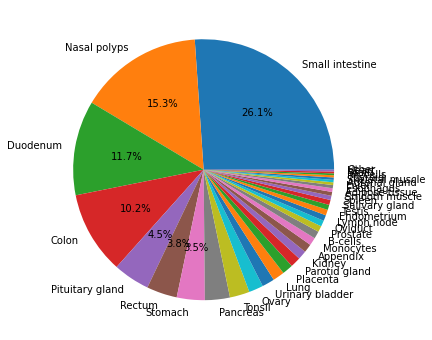

In [40]:
import matplotlib.pyplot as plt

for x in list(np.where(assay_id==6894)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    top_35 = sorted(res.items(), key=lambda pair: -pair[1])[:35]
    top_35_tissues = [item[0] for item in top_35]
    top_35_predictions = [item[1] for item in top_35]

    # Calculate the 'Other' probability
    other = 1 - sum(top_35_predictions)

    # Add 'Other' to the tissues and predictions
    top_35_tissues.append('Other')
    top_35_predictions.append(other)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(top_35_predictions, labels=top_35_tissues, autopct=lambda p: '{:.1f}%'.format(p) if p > 3.4 else '')

# Save the pie chart as an SVG file
plt.savefig('/home/compomics/git/Tissue_prediction/thesis_piechart_celiac.svg', format='svg')
plt.show()


In [ ]:
import shap
for x in list(np.where(assay_id==6894)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    three_highest = sorted(res.items(), key=lambda pair: -pair[1])[:5]
    first, second, third, fourth,fifth = three_highest[0], three_highest[1], three_highest[2], three_highest[3], three_highest[4]
    first_tissue, second_tissue, third_tissue, fourth_tissue, fifth_tissue= first[0], second[0], third[0], fourth[0], fifth[0]
    first_prediction, second_prediction, third_prediction, fourth_prediction, fifth_prediction = first[1], second[1], third[1], fourth[1], fifth[1]
    #If the difference between predictions is very small aka there is a lot of confusion: print all shap plots
    print_all=False
    if first_prediction <= 0.5:
        print_all=True
    newline = '\n'
    print(f'The predictor predicts the following three tissues as most likely: {newline}{first}{newline}{second}{newline}{third}{newline}{fourth}{newline}{fifth}')
    # Calculate Shap values
    choosen_instance = X_diseased.iloc[[x]]
    shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
    shap.initjs()
    if print_all:
        tissue_loc1= classes.index(first_tissue)
        tissue_loc2= classes.index(second_tissue)
        tissue_loc3= classes.index(third_tissue)
        print(first_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc1], choosen_instance, matplotlib=True)) 
        print(second_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc2], choosen_instance, matplotlib=True)) 
        print(third_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc3], choosen_instance, matplotlib=True)) 
    else:
        print(first_tissue)


The true tissue is Small intestine
The predictor predicts the following three tissues as most likely: 
('Small intestine', 0.2608420723868525)
('Nasal polyps', 0.15328592512795938)
('Duodenum', 0.11734241791961832)
('Colon', 0.10235483660861118)
('Pituitary gland', 0.045277998865989245)


Small intestine


Nasal polyps


Duodenum


The true tissue is Small intestine
The predictor predicts the following three tissues as most likely: 
('Small intestine', 0.26084207238685253)
('Nasal polyps', 0.15328592512795938)
('Duodenum', 0.11734241791961832)
('Colon', 0.10235483660861118)
('Pituitary gland', 0.045277998865989245)


Small intestine


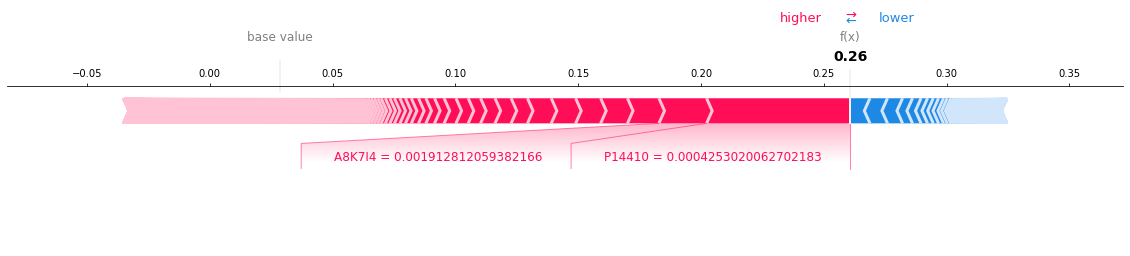

None

Nasal polyps


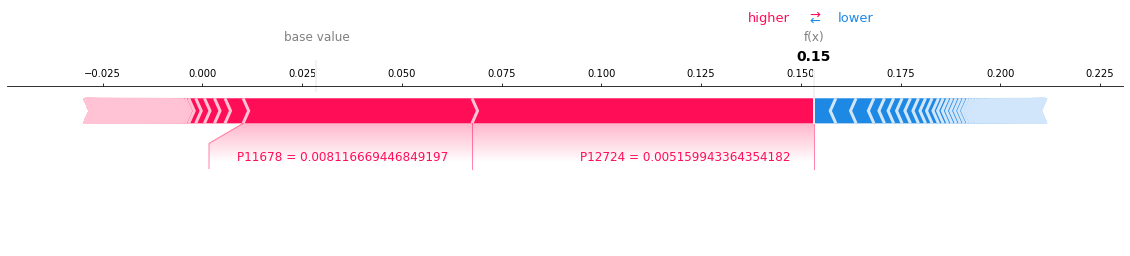

None

Duodenum


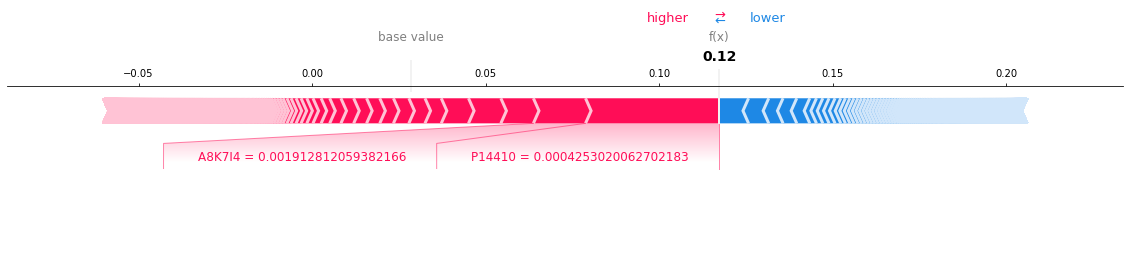

None

In [17]:
import shap
for x in list(np.where(assay_id==6894)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    three_highest = sorted(res.items(), key=lambda pair: -pair[1])[:5]
    first, second, third, fourth,fifth = three_highest[0], three_highest[1], three_highest[2], three_highest[3], three_highest[4]
    first_tissue, second_tissue, third_tissue, fourth_tissue, fifth_tissue= first[0], second[0], third[0], fourth[0], fifth[0]
    first_prediction, second_prediction, third_prediction, fourth_prediction, fifth_prediction = first[1], second[1], third[1], fourth[1], fifth[1]
    #If the difference between predictions is very small aka there is a lot of confusion: print all shap plots
    print_all=False
    if first_prediction <= 0.5:
        print_all=True
    newline = '\n'
    print(f'The predictor predicts the following three tissues as most likely: {newline}{first}{newline}{second}{newline}{third}{newline}{fourth}{newline}{fifth}')
    # Calculate Shap values
    choosen_instance = X_diseased.iloc[[x]]
    shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
    shap.initjs()
    if print_all:
        tissue_loc1= classes.index(first_tissue)
        tissue_loc2= classes.index(second_tissue)
        tissue_loc3= classes.index(third_tissue)
        print(first_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc1], choosen_instance, matplotlib=True)) 
        print(second_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc2], choosen_instance, matplotlib=True)) 
        print(third_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc3], choosen_instance, matplotlib=True)) 
    else:
        print(first_tissue)


In [52]:
diseased_atlas.iloc[2588,:]

assay_id                     9512
cell_type         Urinary bladder
tissue_name       Urinary bladder
disease_status             Cancer
fluid                           0
A0A024RBG1                      0
A0A075B6H7            0.000281774
A0A075B6H8                      0
A0A075B6H9                      0
A0A075B6I0            0.000267916
A0A075B6I1                      0
A0A075B6I7                      0
A0A075B6I9                      0
A0A075B6J1                      0
A0A075B6J6                      0
A0A075B6J9                      0
A0A075B6K0                      0
A0A075B6K2                      0
A0A075B6K4                      0
A0A075B6K5                      0
A0A075B6K6                      0
A0A075B6Q5                      0
A0A075B6R2                      0
A0A075B6R9                      0
A0A075B6S4                      0
A0A075B6S5                      0
A0A087WSY4                      0
A0A087WSY6                      0
A0A087WT03                      0
A0A087WV62    

In [53]:
diseased_atlas[diseased_atlas['assay_id'] == 9512]

assay_id        cell_type      tissue_name disease_status  fluid  \
6248      9512  Urinary bladder  Urinary bladder         Cancer      0   

      A0A024RBG1  A0A075B6H7  A0A075B6H8  A0A075B6H9  A0A075B6I0  ...  Q9Y6X8  \
6248         0.0    0.000282         0.0         0.0    0.000268  ...     0.0   

      Q9Y6X9  Q9Y6Y0  Q9Y6Y1    Q9Y6Y8  Q9Y6Y9  Q9Y6Z4  Q9Y6Z5  Q9Y6Z7  W5XKT8  
6248     0.0     0.0     0.0  0.000098     0.0     0.0     0.0     0.0     0.0  

[1 rows x 11896 columns]

The true tissue is Urinary bladder
The predictor predicts the following three tissues as most likely: 
('Urinary bladder', 0.26377901249279256)
('Stomach', 0.10238409376326706)
('Esophagus', 0.0790635548536194)
('Prostate', 0.05395451082310165)
('Colon', 0.05236603373413801)


Urinary bladder


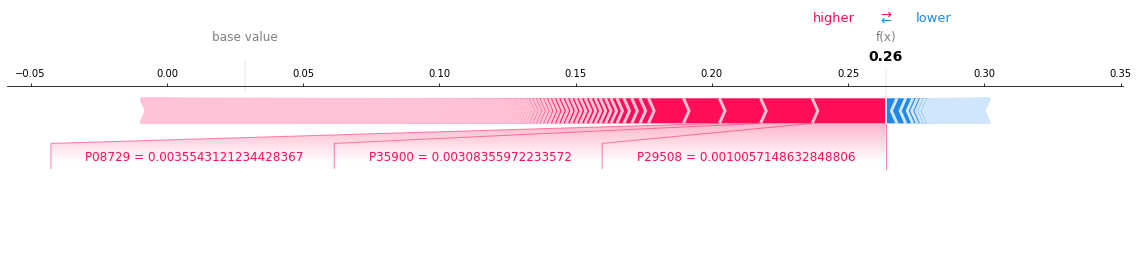

None

Stomach


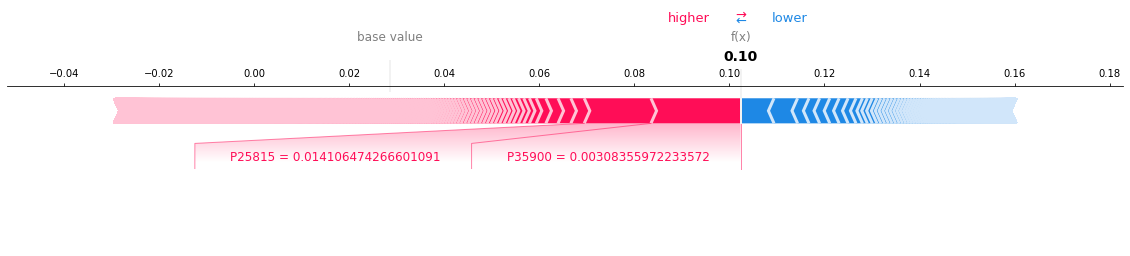

None

Esophagus


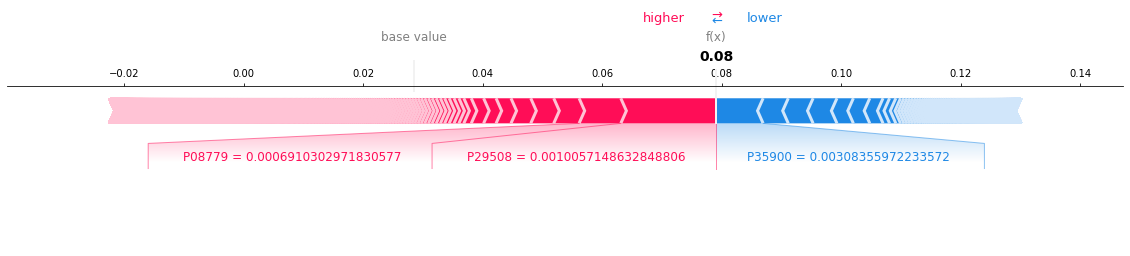

None

In [18]:
import shap
for x in list(np.where(assay_id==9512)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    three_highest = sorted(res.items(), key=lambda pair: -pair[1])[:5]
    first, second, third, fourth,fifth = three_highest[0], three_highest[1], three_highest[2], three_highest[3], three_highest[4]
    first_tissue, second_tissue, third_tissue, fourth_tissue, fifth_tissue= first[0], second[0], third[0], fourth[0], fifth[0]
    first_prediction, second_prediction, third_prediction, fourth_prediction, fifth_prediction = first[1], second[1], third[1], fourth[1], fifth[1]
    #If the difference between predictions is very small aka there is a lot of confusion: print all shap plots
    print_all=False
    if first_prediction <= 0.5:
        print_all=True
    newline = '\n'
    print(f'The predictor predicts the following three tissues as most likely: {newline}{first}{newline}{second}{newline}{third}{newline}{fourth}{newline}{fifth}')
    # Calculate Shap values
    choosen_instance = X_diseased.iloc[[x]]
    shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
    shap.initjs()
    if print_all:
        tissue_loc1= classes.index(first_tissue)
        tissue_loc2= classes.index(second_tissue)
        tissue_loc3= classes.index(third_tissue)
        print(first_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc1], choosen_instance, matplotlib=True))
        print(second_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc2], choosen_instance, matplotlib=True))
        print(third_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc3], choosen_instance, matplotlib=True))
    else:
        print(first_tissue)


Cell cultures

In [58]:
import random
diseased_predictions = pd.DataFrame(columns=['Index', 'True tissue', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5'])
diseased_index = list(np.where(disease_status=='Cell culture')[0])
for _ in range(15):
    for i in random.sample(diseased_index,1):
        test_sample = X_diseased.iloc[i:i+1]
        test_tissue = y_diseased.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest_opt)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = [i, test_tissue, pred1, pred2, pred3, pred4, pred5]
diseased_predictions

Index      True tissue                            Pred1  \
0   2471              Eye  (Pancreas, 0.14949835953332574)   
1   3098   Uterine cervix  (Pancreas, 0.23682339853314277)   
2   3141             hMSC  (Pancreas, 0.15896738609953204)   
3   2150             Lung  (Pancreas, 0.14369022913518328)   
4    699            Colon  (Pancreas, 0.19114369439776577)   
5    814            Colon  (Pancreas, 0.21031091891665082)   
6    779            Colon  (Pancreas, 0.19634987840294343)   
7    230            Liver  (Pancreas, 0.12310784548069308)   
8    106            Liver  (Pancreas, 0.19037920213787762)   
9    551            Colon   (Pancreas, 0.1647432577506625)   
10  2121             Lung    (B-cells, 0.1079342482507117)   
11   432            Liver  (Pancreas, 0.17279243380339643)   
12  2746   Umbilical cord  (Pancreas, 0.09490195040454488)   
13   161            Liver  (Pancreas, 0.24286780470208894)   
14  2908             Skin   (Pancreas, 0.2545181340904395)   

                               Pred2                             Pred3  \
0     (B-cells, 0.08213827441293535)  (Monocytes, 0.08180900888488923)   
1     (B-cells, 0.08193841556271207)     (Kidney, 0.07526616601337326)   
2       (Ovary, 0.11752850322734444)  (Monocytes, 0.07379959443088967)   
3      (Kidney, 0.09632769741654888)    (B-cells, 0.06690045584860065)   
4       (B-cells, 0.088534598253293)  (Monocytes, 0.06923959749616684)   
5     (B-cells, 0.09729748296331568)  (Monocytes, 0.09163051154343416)   
6      (Kidney, 0.08078990807858505)    (Stomach, 0.07087930104452622)   
7      (Kidney, 0.07404857823869604)     (Testis, 0.06787277292725627)   
8     (B-cells, 0.07200946113436364)    (Stomach, 0.07137840534275385)   
9     (Stomach, 0.10048542169345175)     (Kidney, 0.08144174983679187)   
10  (Monocytes, 0.09046667820288637)      (Ovary, 0.06887863738340418)   
11    (B-cells, 0.10451748722050051)     (Testis, 0.09114946798880223)   
12      (Ovary, 0.09417152768025144)     (Spleen, 0.06654708589857619)   
13    (B-cells, 0.08007340855241653)     (Kidney, 0.06950292413605827)   
14     (Kidney, 0.09635406729260797)    (B-cells, 0.07533246791450013)   

                                     Pred4  \
0             (Heart, 0.06257444801744987)   
1          (Monocytes, 0.0680948983158949)   
2           (B-cells, 0.05946757245514958)   
3           (Thyroid, 0.05636248443898715)   
4   (Pituitary gland, 0.06567239837945335)   
5           (Testis, 0.062345007365520955)   
6   (Urinary bladder, 0.04939347195355438)   
7    (Salivary gland, 0.06640960445753523)   
8   (Urinary bladder, 0.06726455258766187)   
9   (Urinary bladder, 0.05139663451881908)   
10        (Pancreas, 0.061293324722086914)   
11            (Brain, 0.09015817569575667)   
12       (Endometrium, 0.0635329695752769)   
13        (Monocytes, 0.06659012915363338)   
14             (Lung, 0.05692528561559758)   

                                     Pred5  
0            (Testis, 0.05990746857267628)  
1            (Testis, 0.05209646553045805)  
2   (Salivary gland, 0.049957018588668564)  
3              (Lung, 0.05281274880159974)  
4            (Oviduct, 0.0618617631808722)  
5           (Stomach, 0.04889785309769229)  
6            (Testis, 0.04824920236351838)  
7          (Placenta, 0.04721752152443324)  
8            (Testis, 0.06653150594101916)  
9            (Colon, 0.050872943324163374)  
10  (Pituitary gland, 0.05100490031032767)  
11        (Monocytes, 0.07599731991745722)  
12             (Lung, 0.06327270366590607)  
13         (Stomach, 0.055775130587220736)  
14            (Ovary, 0.04585906397879935)

In [ ]:
diseased_atlas.iloc[3098,:]

In [65]:
row = X_diseased.iloc[[list(np.where(assay_id==9457)[0])[0]]]
num_zeros = (row == 0).sum().sum()
num_zeros

3078

In [62]:
diseased_atlas[diseased_atlas['assay_id'] == 9457]

10495


The true tissue is Uterine cervix
The predictor predicts the following three tissues as most likely: 
('Pancreas', 0.23682339853314277)
('B-cells', 0.08193841556271207)
('Kidney', 0.07526616601337326)
('Monocytes', 0.0680948983158949)
('Testis', 0.05209646553045805)


Pancreas


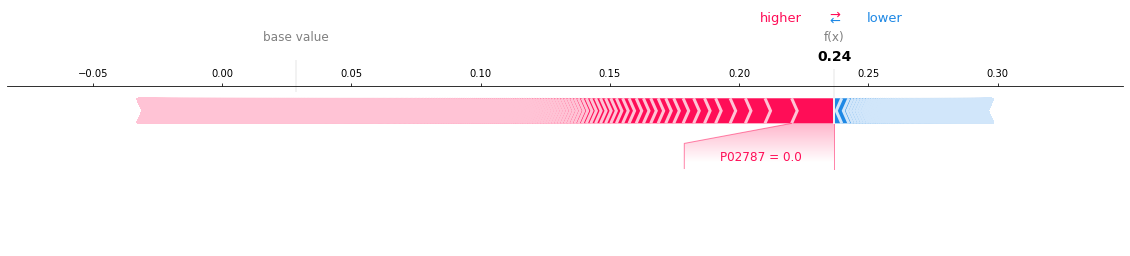

None

B-cells


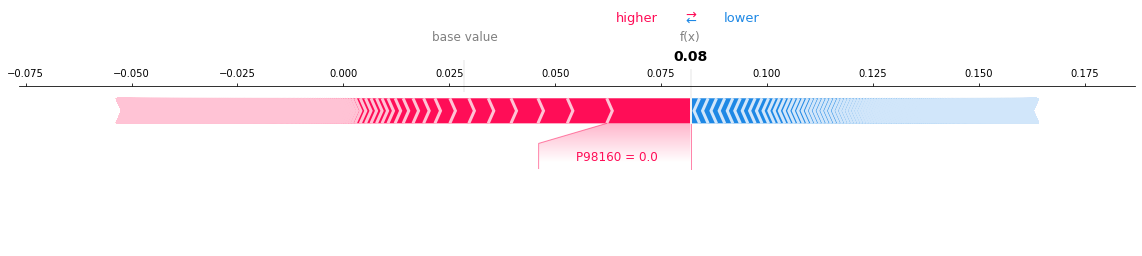

None

Kidney


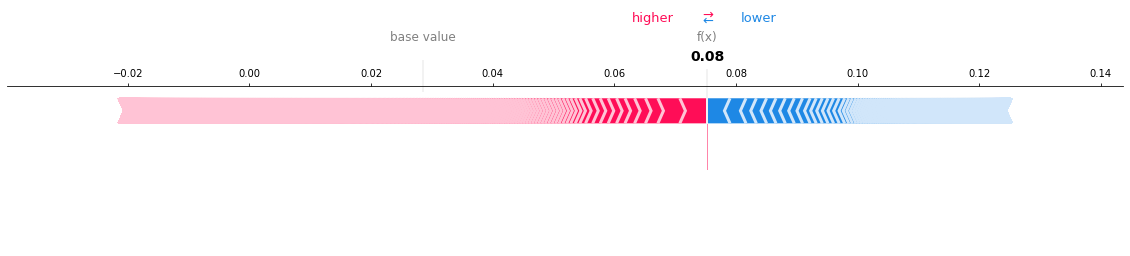

None

In [19]:
import shap
for x in list(np.where(assay_id==9457)[0]):
    explainer = shap.Explainer(forest_opt)
    true_tissue = y_diseased.iloc[x,:].values.item()
    print(f'The true tissue is {true_tissue}')
    probs = forest_opt.predict_proba(X_diseased.iloc[[x]]).tolist()[0]
    classes = forest_opt.classes_.tolist()

    res = {classes[i]: probs[i] for i in range(len(classes))}
    three_highest = sorted(res.items(), key=lambda pair: -pair[1])[:5]
    first, second, third, fourth,fifth = three_highest[0], three_highest[1], three_highest[2], three_highest[3], three_highest[4]
    first_tissue, second_tissue, third_tissue, fourth_tissue, fifth_tissue= first[0], second[0], third[0], fourth[0], fifth[0]
    first_prediction, second_prediction, third_prediction, fourth_prediction, fifth_prediction = first[1], second[1], third[1], fourth[1], fifth[1]
    #If the difference between predictions is very small aka there is a lot of confusion: print all shap plots
    print_all=False
    if first_prediction <= 0.5:
        print_all=True
    newline = '\n'
    print(f'The predictor predicts the following three tissues as most likely: {newline}{first}{newline}{second}{newline}{third}{newline}{fourth}{newline}{fifth}')
    # Calculate Shap values
    choosen_instance = X_diseased.iloc[[x]]
    shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
    shap.initjs()
    if print_all:
        tissue_loc1= classes.index(first_tissue)
        tissue_loc2= classes.index(second_tissue)
        tissue_loc3= classes.index(third_tissue)
        print(first_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc1], choosen_instance, matplotlib=True))
        print(second_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc2], choosen_instance, matplotlib=True))
        print(third_tissue)
        display(shap.force_plot(explainer.expected_value[1], shap_values[tissue_loc3], choosen_instance, matplotlib=True))
    else:
        print(first_tissue)


In [60]:
select_assays= [6894, 2588, 9512, 9457]
diseased_subset = diseased_atlas[diseased_atlas['assay_id'].isin(select_assays)]
# add ten random samples
diseased_subset = pd.concat([diseased_subset, diseased_atlas.sample(10)])
diseased_subset.to_csv('/home/compomics/git/MLMarker_app/data/test_sample.csv', index=False)